# Yellow Fever Epidemic Modeling: Senegal 2002 Outbreak 

This notebook demonstrates the application of a compartmental SEIR  model with vaccination intervention of the Yellow Fever outbreak in Touba, Senegal (population: 800,000). The data was sourced from WHO archives. 

In [83]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path 
import json 
import warnings 
warnings.filterwarnings('ignore')

import sys, os 
sys.path.append(os.path.abspath(os.path.join('..','src')))
from epimodels.yellow_fever_models import YellowFeverModel, create_vaccination_function
from epimodels.fitting.parameter_estimation import ParameterEstimator, calculate_model_metrics
from epimodels.utils.visualizations_yellow_fever import YellowFeverVisualizer

# set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Loading and Preparation

In [84]:
# Historical WHO outbreak data

data = {
    'date': ['2002-10-04', '2002-10-11', '2002-10-17', '2002-10-24', '2002-10-31', '2002-11-20', '2002-11-28'],
    'days_since_start': [0, 7, 13, 20, 27, 47, 55],
    'cases_cumulative': [12, 15, 18, 41, 45, 57, 60],
    'deaths_cumulative': [0, 2, 2, 4, 4, 10, 11],
    'new_cases': [12, 3, 3, 23, 4, 12, 3],
    'new_deaths': [0, 2, 0, 2, 0, 6, 1]
}

data = pd.DataFrame(data)
data['date'] = pd.to_datetime(data['date'])

print("Historical Data Overview:")
print(f"Number of observations: {len(data)}")
print(f"Time span: {data['days_since_start'].min()} to {data['days_since_start'].max()} days")
print(f"Date range: {data['date'].min().date()} to {data['date'].max().date()}")
print(f"Total cases: {data['cases_cumulative'].max()}")
print(f"Total deaths: {data['deaths_cumulative'].max()}")
print(f"Case Fatality Rate: {data['deaths_cumulative'].iloc[-1] / data['cases_cumulative'].iloc[-1] * 100:.1f}%")

print("\nComplete Dataset:")
display(data)

Historical Data Overview:
Number of observations: 7
Time span: 0 to 55 days
Date range: 2002-10-04 to 2002-11-28
Total cases: 60
Total deaths: 11
Case Fatality Rate: 18.3%

Complete Dataset:


,date,days_since_start,cases_cumulative,deaths_cumulative,new_cases,new_deaths
0,2002-10-04,0,12,0,12,0
1,2002-10-11,7,15,2,3,2
2,2002-10-17,13,18,2,3,0
3,2002-10-24,20,41,4,23,2
4,2002-10-31,27,45,4,4,0
5,2002-11-20,47,57,10,12,6
6,2002-11-28,55,60,11,3,1


### Visualize Raw Data

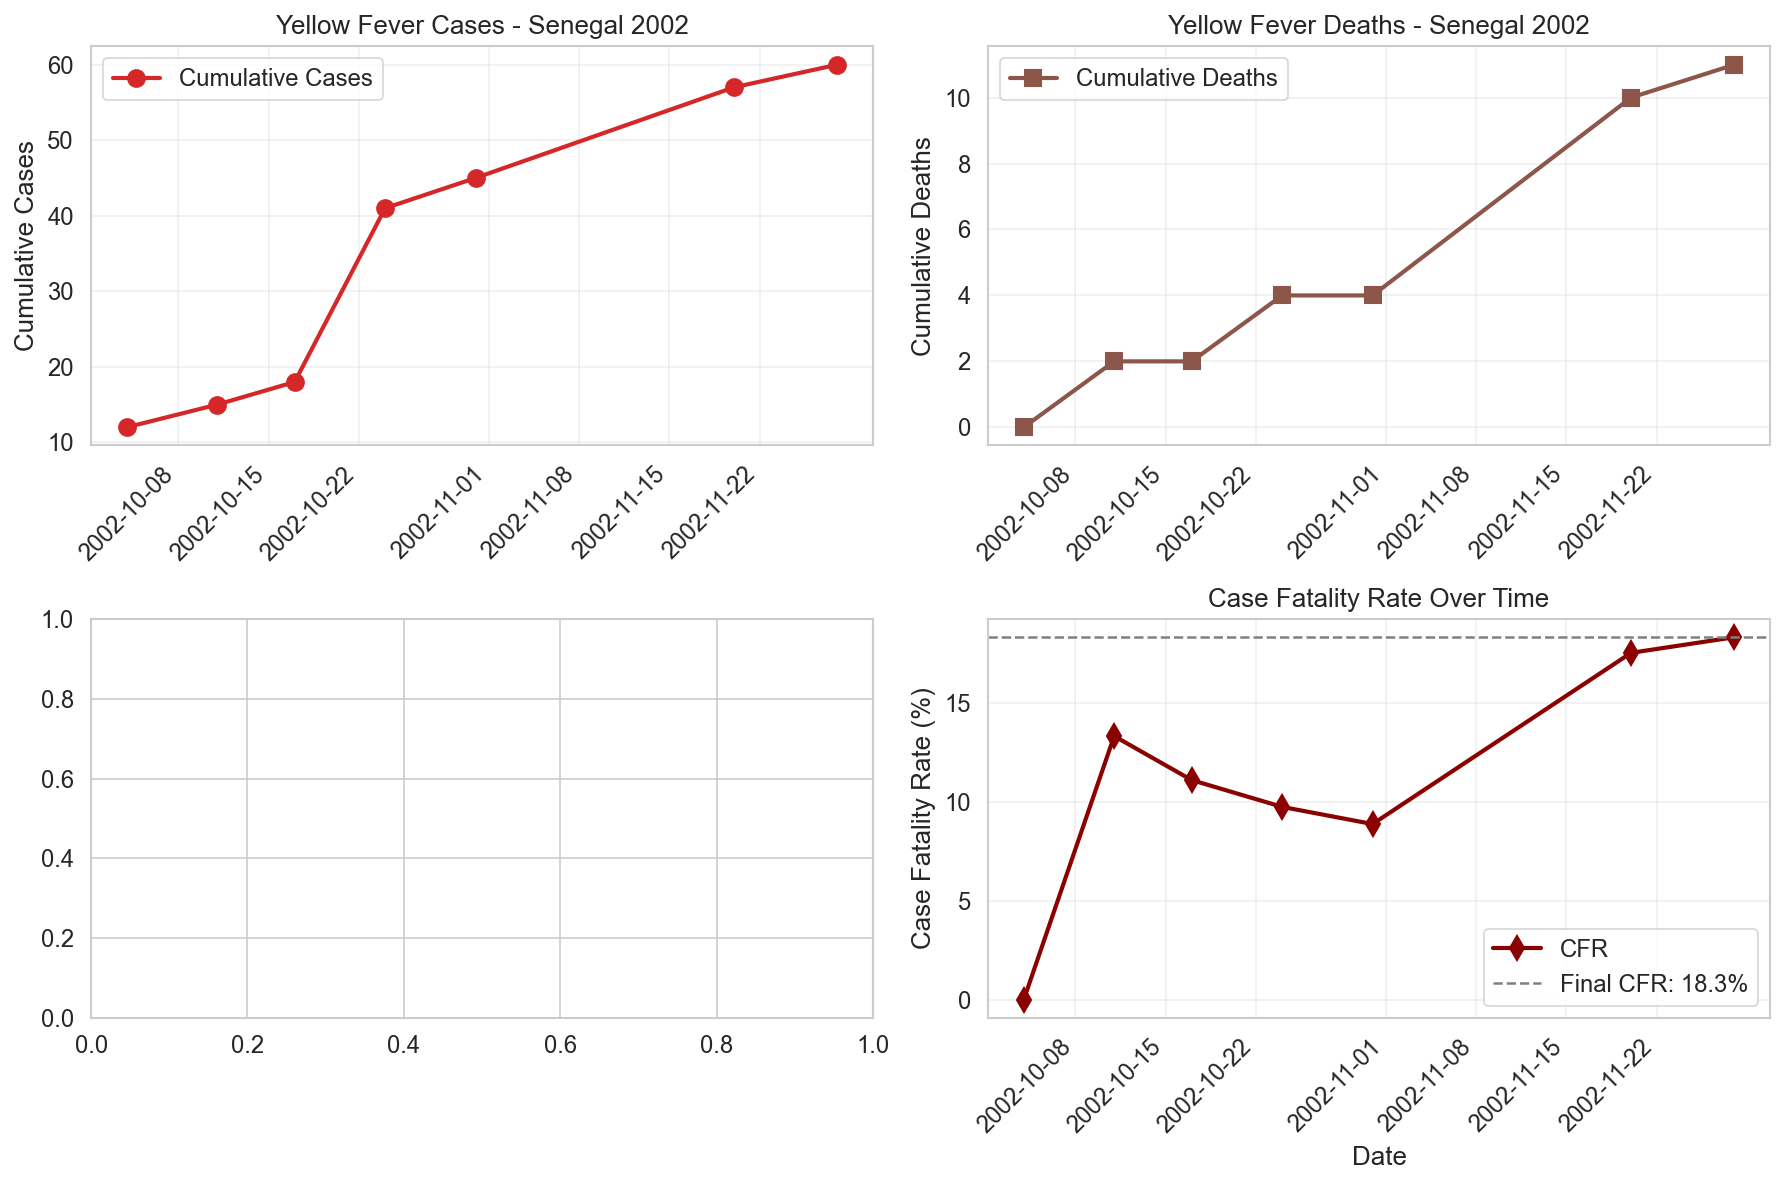

In [85]:
viz = YellowFeverVisualizer()
fig = viz.plot_data_overview(data)
plt.tight_layout()
plt.show()

### Summary Statistics

In [86]:
summary_stats = {
    'Total Cases': data['cases_cumulative'].max(),
    'Total Deaths': data['deaths_cumulative'].max(),
    'Case Fatality Rate (%)': round(data['deaths_cumulative'].iloc[-1] / data['cases_cumulative'].iloc[-1] * 100, 2),
    'Peak Daily Cases': data['new_cases'].max(),
    'Peak Daily Deaths': data['new_deaths'].max(),
    'Observation Period (days)': data['days_since_start'].max(),
    'Attack Rate (%)': round(data['cases_cumulative'].max() / 800000 * 100, 4)
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])
display(summary_df)

,Metric,Value
0,Total Cases,60.0000
1,Total Deaths,11.0000
2,Case Fatality Rate (%),18.3300
3,Peak Daily Cases,23.0000
4,Peak Daily Deaths,6.0000
5,Observation Period (days),55.0000
6,Attack Rate (%),0.0075


## Model Setup

### Model Structure

For this analysis, I use a compartmental SEIR model with vaccination: 

**Compartments**
- **S**: Susceptible individuals
- **E**: Exposed individuals (infected, but not yet infectious)
- **I**: Infectious individuals 
- **R**: Recovered individuals (natural immunity)
- **V**: Vaccinated (vaccine-induced immunity)
- **D**: Deaths (cumulative) 

**Parameters**
- $\beta$: Transmission rate 
- $\sigma$: Incubation period (days) 
- $\gamma$: Infectious period (days) 
- $\alpha$: Mortality rate 
### Differential Equations: 

$$\frac{dS}{dt} = -\beta \frac{SI}{N} - V(t)S$$
$$\frac{dE}{dt} = \beta \frac{SI}{N} - \sigma E$$
$$\frac{dI}{dt} = \sigma E - \gamma I - \alpha I$$
$$\frac{dR}{dt} = \gamma I $$
$$\frac{dV}{dt} = V(t)S $$
$$\frac{dD}{dt} = \alpha I $$





In [87]:
# vaccination function starting on October 1, 2002 (day 259)
vaccination_func = create_vaccination_function(
    start_date=-3,
    vaccination_rate=0.01,       # 1% of susceptibles per day
    ramp_duration=7.0,
    vaccine_efficiency=0.95
)

# initialize model with example parameters
# Initialize model with example parameters
model_example = YellowFeverModel(
    beta=0.5,           # Transmission rate
    sigma=1/6,          # Incubation period ~6 days
    gamma=1/7,          # Infectious period ~7 days
    alpha=0.15/7,       # Mortality rate (CFR ~15%)
    vaccination_func=vaccination_func,
    population=800000
)

print(model_example)
print(f"\nWith these parameters, R₀ = {model_example.calculate_r0():.4f}")


YellowFeverModel(
  β=0.5000 (transmission rate)
  σ=0.1667 (1/incubation)
  γ=0.1429 (recovery rate)
  α=0.0214 (mortality rate)
  N=800000 (population)
  R₀=3.0435
)

With these parameters, R₀ = 3.0435


## Parameter Estimation via MLE

Fit the model to the actual Senegalese outbreak data using Maximum Likelihood Estimation (MLE). 

### Setup Parameter Estimator

In [88]:
# initialize parameter estimator
estimator = ParameterEstimator(
    data=data,
    population=800000,
    fixed_params={
        'sigma':1/6,    # biorealistic six day incubation period
        'gamma':1/7,    # biorealistic seven day infectious period 
    }
)

print("Parameter Estimator initialized")
print(f"Fixed parameters: {estimator.fixed_params}")
print(f"Data points: {len(estimator.t_data)}")

Parameter Estimator initialized
Fixed parameters: {'sigma': 0.16666666666666666, 'gamma': 0.14285714285714285}
Data points: 7


### Define Initial Parameter Guess

In [89]:
# initial parameter guess
observed_CFR = 11/60        # 18.3%
infectious_period = 7       # 7 days
alpha_initial = observed_CFR / infectious_period

initial_guess = {
    'beta': 0.5,                # transmission rate
    'alpha': alpha_initial,              # mortality rate (CFR ~18%)
    'vaccination_rate': 0.01,    # 1% vaccinated per day
    'vaccination_start': -3     # Oct 1, 2002
}

print("Initial parameter guess:")
for param, value in initial_guess.items():
    print(f"  {param:20s}: {value:.6f}")

# test simulation with initial guess
cases_init, deaths_init = estimator.simulate_model(initial_guess, initial_infected=10)

print("\nInitial guess predictions:")
print(f"  Final cases:  {cases_init[-1]:.0f}  (Observed: {data['cases_cumulative'].iloc[-1]})")
print(f"  Final deaths: {deaths_init[-1]:.0f}  (Observed: {data['deaths_cumulative'].iloc[-1]})")

Initial parameter guess:
  beta                : 0.500000
  alpha               : 0.026190
  vaccination_rate    : 0.010000
  vaccination_start   : -3.000000

Initial guess predictions:
  Final cases:  3182  (Observed: 60)
  Final deaths: 248  (Observed: 11)


### Run Parameter Optimization (MLE)

In [90]:
print("Running Maximum Likelihood Estimation...")

# fit model to data
fitted_params, result = estimator.fit_mle(
    initial_guess=initial_guess,
    method='L-BFGS-B',
    use_global=False
)

# display results
print("PARAMETER ESTIMATION RESULTS")
print("\nFitted Parameters:")
for name, value in fitted_params.items():
    print(f"  {name:20s}: {value:.6f}")

print("\nFixed Parameters:")
for name, value in estimator.fixed_params.items():
    print(f"  {name:20s}: {value:.6f}")

print("\nOptimization Info:")
for key, value in result.items():
    if value is not None:
        print(f"  {key:25s}: {value}")

# calculate R0 with fitted parameters
all_params = {**estimator.fixed_params, **fitted_params}
vaccination_func_fitted = create_vaccination_function(
    start_date=fitted_params['vaccination_start'],
    vaccination_rate=fitted_params['vaccination_rate']
)

model_fitted = YellowFeverModel(
    beta=fitted_params['beta'],
    sigma=all_params['sigma'],
    gamma=all_params['gamma'],
    alpha=fitted_params['alpha'],
    vaccination_func=vaccination_func_fitted,
    population=800000
)

r0 = model_fitted.calculate_r0()
print(f"Basic Reproduction Number R₀ = {r0:.4f}")

Running Maximum Likelihood Estimation...
PARAMETER ESTIMATION RESULTS

Fitted Parameters:
  beta                : 0.206002
  alpha               : 0.032630
  vaccination_rate    : 0.008573
  vaccination_start   : -2.999891

Fixed Parameters:
  sigma               : 0.166667
  gamma               : 0.142857

Optimization Info:
  success                  : True
  neg_log_likelihood       : 32.3060014762421
  AIC                      : 72.6120029524842
  BIC                      : 75.16823227094524
  n_iterations             : 160
  message                  : CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Basic Reproduction Number R₀ = 1.1739


### Simulate Fitted Model

In [91]:
# simulate with fitted parameters
initial_conditions = {
    'S': 799990,
    'E': 0,
    'I': 10,
    'R': 0,
    'V': 0,
    'D': 0
}

t_eval = np.linspace(0, 55, 56)
t_fitted, y_fitted = model_fitted.simulate(
    initial_conditions=initial_conditions,
    t_span=(0, 55),
    t_eval=t_eval
)

print("Fitted model simulation complete")
print(f"  Time points: {len(t_fitted)}")
print(f"  Simulation span: {t_fitted[0]:.0f} to {t_fitted[-1]:.0f} days")

Fitted model simulation complete
  Time points: 56
  Simulation span: 0 to 55 days


### Evaluate Model Fit Quality

In [92]:
# calculate fit metrics
from scipy.interpolate import interp1d

S_fit, E_fit, I_fit, R_fit, V_fit, D_fit = y_fitted
cases_model = E_fit + I_fit + R_fit + D_fit

# interpolate to data time points
f_cases = interp1d(t_fitted, cases_model, kind='cubic')
f_deaths = interp1d(t_fitted, D_fit, kind='cubic')

t_data = data['days_since_start'].values
cases_pred = f_cases(t_data)
deaths_pred = f_deaths(t_data)

# calculate metrics
metrics_cases = calculate_model_metrics(data['cases_cumulative'].values, cases_pred)
metrics_deaths = calculate_model_metrics(data['deaths_cumulative'].values, deaths_pred)

print("Model Fit Quality:")
print("\nCases:")
for metric, value in metrics_cases.items():
    print(f"  {metric:15s}: {value:.4f}")

print("\nDeaths:")
for metric, value in metrics_deaths.items():
    print(f"  {metric:15s}: {value:.4f}")

# Create comparison table
comparison = pd.DataFrame({
    'Date': data['date'],
    'Observed Cases': data['cases_cumulative'],
    'Predicted Cases': cases_pred.round(1),
    'Observed Deaths': data['deaths_cumulative'],
    'Predicted Deaths': deaths_pred.round(1)
})

print("Observed vs Predicted:")
display(comparison)

Model Fit Quality:

Cases:
  MAE            : 4.2601
  RMSE           : 5.0151
  R2             : 0.9285
  MAPE           : 18.3155

Deaths:
  MAE            : 0.6399
  RMSE           : 0.8013
  R2             : 0.9574
  MAPE           : 15.6255
Observed vs Predicted:


,Date,Observed Cases,Predicted Cases,Observed Deaths,Predicted Deaths
0,2002-10-04,12,10.0,0,0.0
1,2002-10-11,15,19.9,2,1.6
2,2002-10-17,18,26.4,2,2.7
3,2002-10-24,41,33.7,4,4.0
4,2002-10-31,45,40.7,4,5.4
5,2002-11-20,57,57.5,10,8.9
6,2002-11-28,60,62.5,11,10.1


In [93]:
# Comprehensive diagnostic
print("="*80)
print("DEBUGGING MODEL FIT")
print("="*80)

# 1. Check parameters
print("\n1. FITTED PARAMETERS:")
for k, v in fitted_params.items():
    print(f"   {k:20s}: {v:.10f}")
    if k == 'alpha' and v < 0.001:
        print("   ⚠️  WARNING: Alpha is very small!")

# 2. Check optimization
print(f"\n2. OPTIMIZATION:")
print(f"   Success: {result.get('success')}")
print(f"   Iterations: {result.get('n_iterations', 'N/A')}")
print(f"   Final neg-log-likelihood: {result.get('neg_log_likelihood'):.4f}")

# 3. Check simulation
print(f"\n3. SIMULATION OUTPUT:")
print(f"   Simulation time span: {t_fitted[0]:.0f} - {t_fitted[-1]:.0f} days")
print(f"   Max I(t): {I_fit.max():.2f}")
print(f"   Final D(t): {D_fit[-1]:.2f}")
print(f"   Deaths ever > 0? {(D_fit > 0.01).any()}")

# 4. Manual death calculation
print(f"\n4. EXPECTED DEATHS:")
total_infections = (E_fit + I_fit + R_fit + D_fit).max()
expected_deaths = total_infections * (11/60)  # Observed CFR
print(f"   Total infections: {total_infections:.2f}")
print(f"   Expected deaths (18.3% CFR): {expected_deaths:.2f}")
print(f"   Actual predicted deaths: {D_fit[-1]:.2f}")

print("\n" + "="*80)

DEBUGGING MODEL FIT

1. FITTED PARAMETERS:
   beta                : 0.2060024950
   alpha               : 0.0326295801
   vaccination_rate    : 0.0085727405
   vaccination_start   : -2.9998913811

2. OPTIMIZATION:
   Success: True
   Iterations: 160
   Final neg-log-likelihood: 32.3060

3. SIMULATION OUTPUT:
   Simulation time span: 0 - 55 days
   Max I(t): 10.00
   Final D(t): 10.11
   Deaths ever > 0? True

4. EXPECTED DEATHS:
   Total infections: 62.48
   Expected deaths (18.3% CFR): 11.46
   Actual predicted deaths: 10.11



## Visualize Model Fit

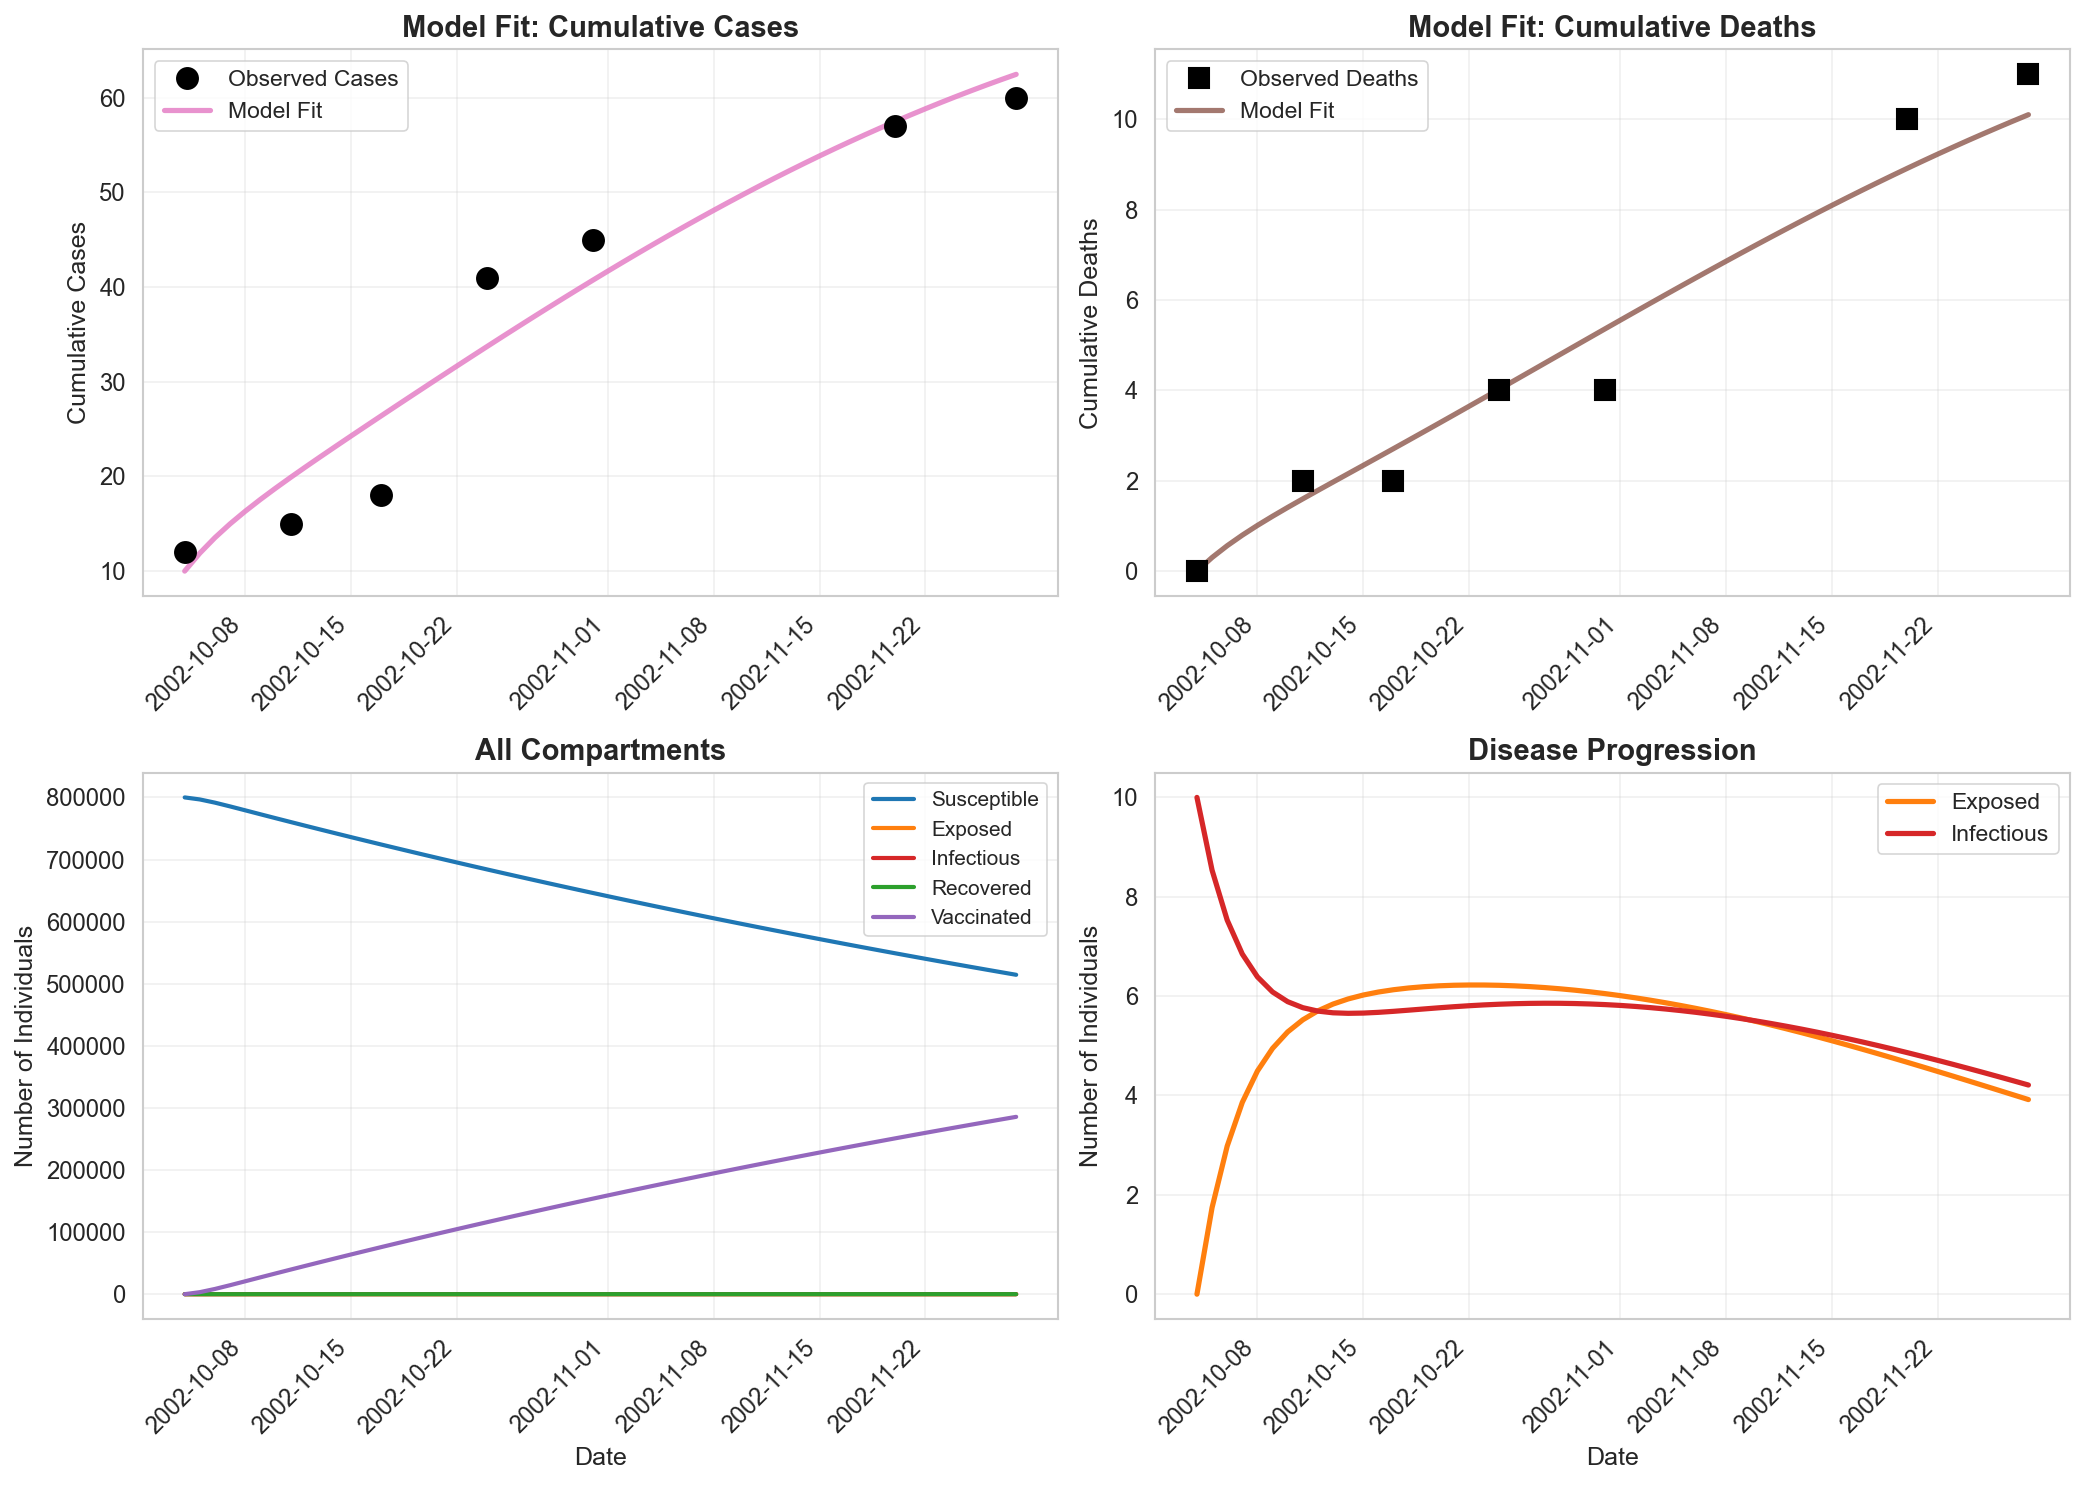

In [94]:
# plot model fit to data
fig = viz.plot_model_fit(
    data=data,
    t_model=t_fitted,
    y_model=y_fitted,
    show_compartments=True
)
plt.show()


### Residual Analysis

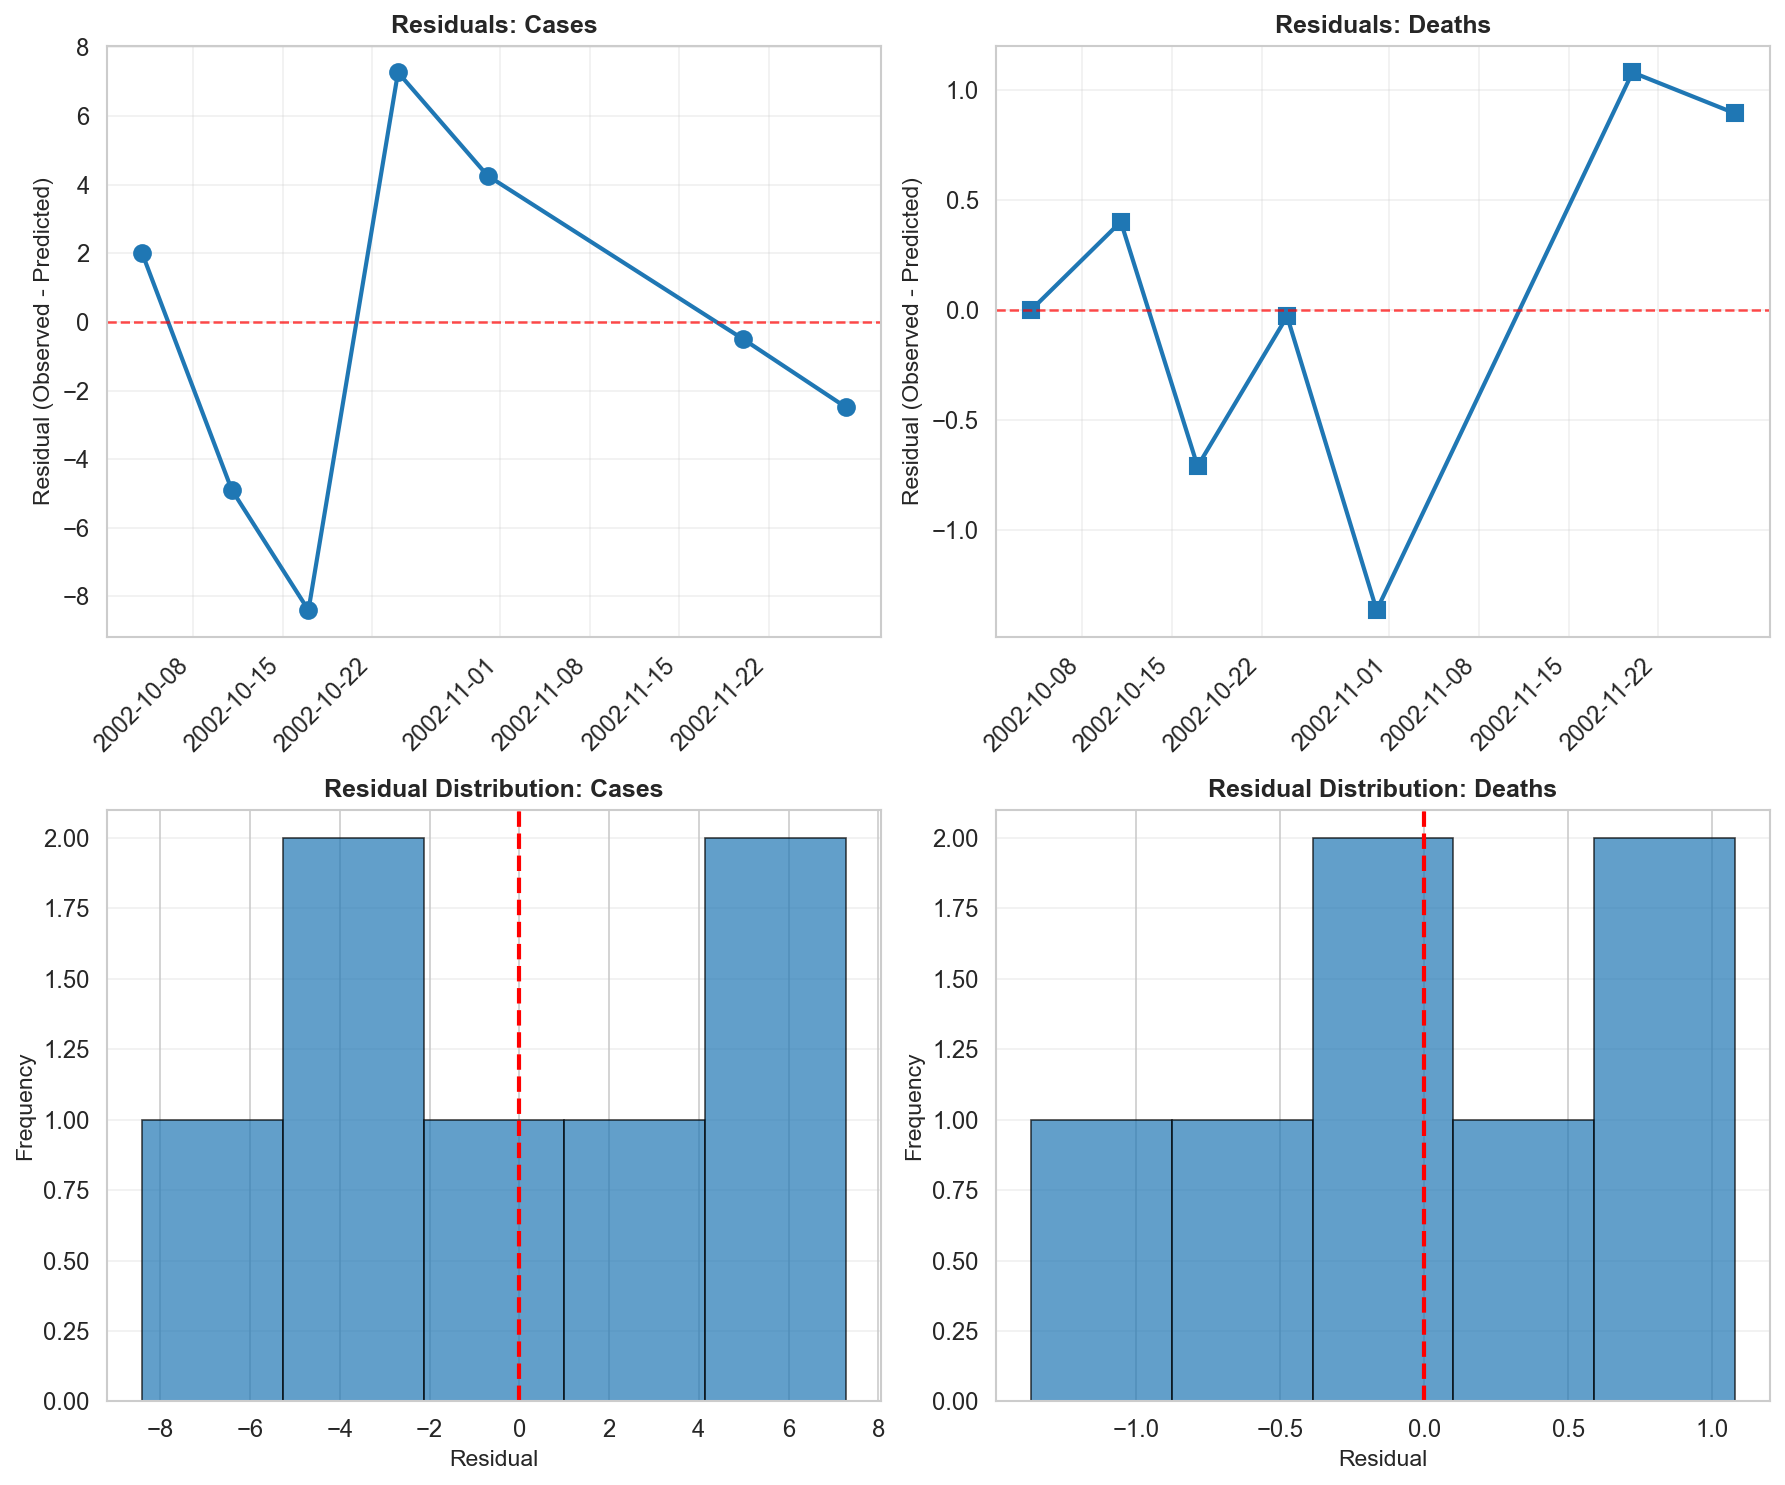

In [95]:
# plot residuals
fig = viz.plot_residuals(
    data=data,
    t_model=t_fitted,
    y_model=y_fitted
)
plt.show()

### Effective Reproduction Number over Time

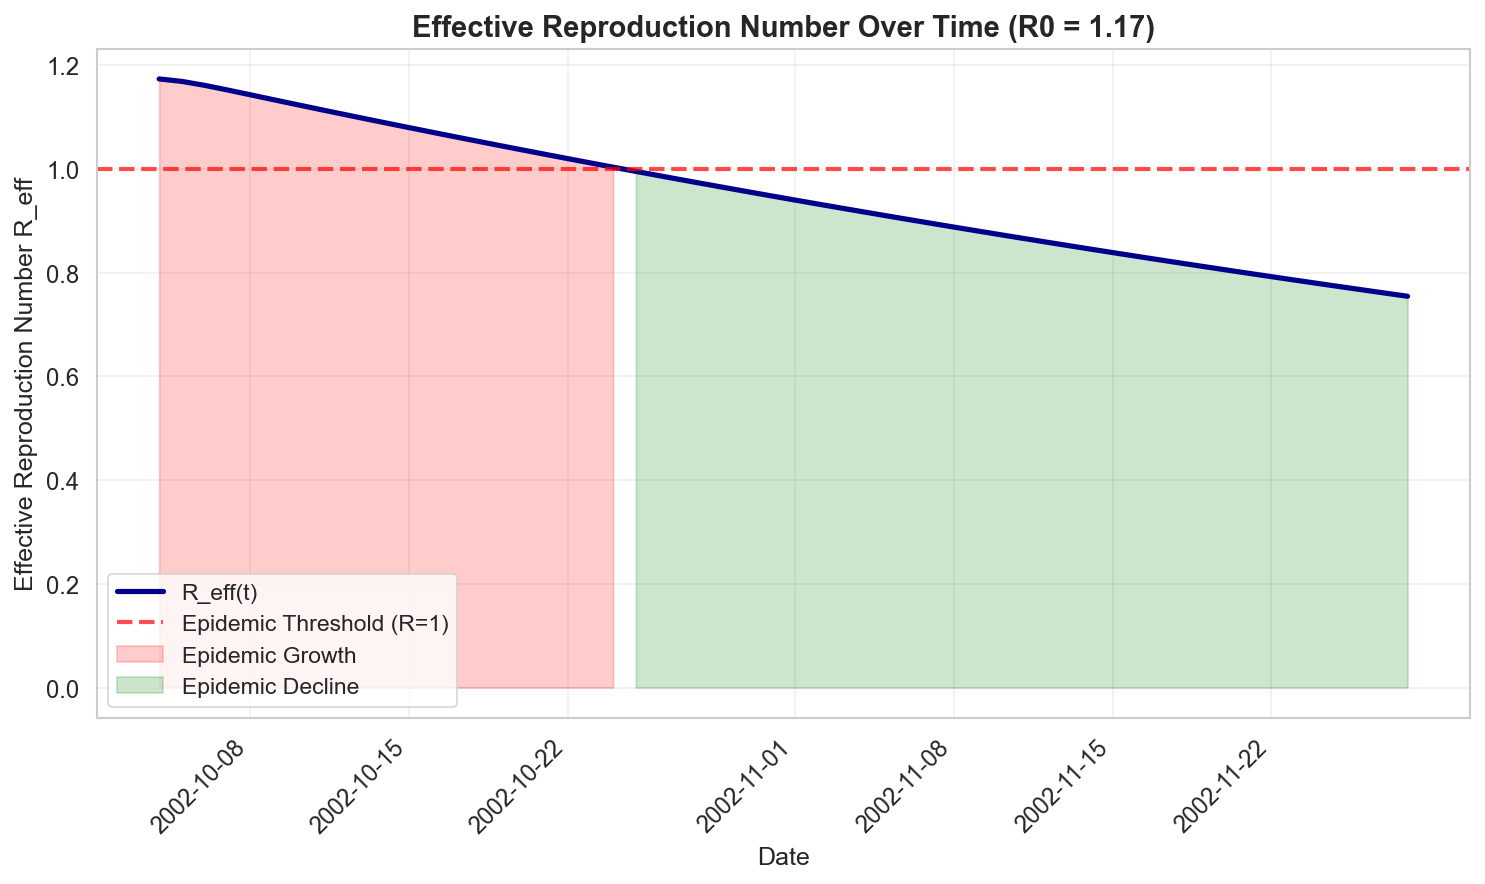

R0 = 1.174 (basic reproduction number)
  - When R_eff > 1: epidemic grows
  - When R_eff < 1: epidemic declines
  - Vaccination reduces R_eff by decreasing susceptibles


In [96]:
# plot r effective
fig = viz.plot_r_effective(
    t=t_fitted,
    S=S_fit,
    r0=r0,
    N=800000
)
plt.show()
print(f"R0 = {r0:.3f} (basic reproduction number)")
print(f"  - When R_eff > 1: epidemic grows")
print(f"  - When R_eff < 1: epidemic declines")
print(f"  - Vaccination reduces R_eff by decreasing susceptibles")

## Counterfactual Analysis

What would have happened without a vaccine? Below I compare three scenarios:
1) Baseline: With vaccination (fitted model)
2) No vaccination: counterfactual scenario 
3) Early vaccination: what if vaccination started 2 weeks earlier?

### Scenario 1: Baseline (with vaccination)

In [97]:
# store baseline results
scenarios = {}
scenarios['Baseline (w/vaccination)'] = (t_fitted, y_fitted)

baseline_cases = (E_fit + I_fit + R_fit + D_fit)[-1]
baseline_deaths = D_fit[-1]
baseline_peak = I_fit.max()

print("Baseline Scenario:")
print(f"  Total cases:      {baseline_cases:.0f}")
print(f"  Total deaths:     {baseline_deaths:.0f}")
print(f"  Peak infections:  {baseline_peak:.0f}")
print(f"  Attack rate:      {(baseline_cases / 800000 * 100):.3f}%")

Baseline Scenario:
  Total cases:      62
  Total deaths:     10
  Peak infections:  10
  Attack rate:      0.008%


### Scenario 2: No Vaccination (counterfactual)

In [98]:
# create a model without vaccination
model_no_vax = YellowFeverModel(
    beta=fitted_params['beta'],
    sigma=all_params['sigma'],
    gamma=all_params['gamma'],
    alpha=fitted_params['alpha'],
    vaccination_func=None, 
    population=800000
)

# simulate
t_no_vax, y_no_vax = model_no_vax.simulate(
    initial_conditions=initial_conditions,
    t_span=(0,56),
    t_eval=t_eval
)

scenarios['No Vaccination'] = (t_no_vax, y_no_vax)

S_no, E_no, I_no, R_no, V_no, D_no = y_no_vax
no_vax_cases = (E_no + I_no + R_no + D_no)[-1]
no_vax_deaths = D_no[-1]
no_vax_peak = I_no.max()

print("\nNo Vaccination Scenario:")
print(f"  Total cases:      {no_vax_cases:.0f}")
print(f"  Total deaths:     {no_vax_deaths:.0f}")
print(f"  Peak infections:  {no_vax_peak:.0f}")
print(f"  Attack rate:      {(no_vax_cases / 800000 * 100):.3f}%")



No Vaccination Scenario:
  Total cases:      97
  Total deaths:     14
  Peak infections:  11
  Attack rate:      0.012%


### Scenario 3: Early Vaccination (2 weeks earlier)

In [99]:
# vaccination 2 weeks earlier (day -17 instead of -3)
vaccination_func_early = create_vaccination_function(
    start_date=-17,
    vaccination_rate=fitted_params['vaccination_rate']
)

model_early = YellowFeverModel(
    beta=fitted_params['beta'],
    sigma=all_params['sigma'],
    gamma=all_params['gamma'],
    alpha=fitted_params['alpha'],
    vaccination_func=vaccination_func_early,
    population=800000
)

t_early, y_early = model_early.simulate(
    initial_conditions=initial_conditions,
    t_span=(0, 56),
    t_eval=t_eval
)

scenarios['Early Vaccination (2 weeks)'] = (t_early, y_early)

S_early, E_early, I_early, R_early, V_early, D_early = y_early
early_cases = (E_early + I_early + R_early + D_early)[-1]
early_deaths = D_early[-1]
early_peak = I_early.max()

print("\nEarly Vaccination Scenario:")
print(f"  Total cases:      {early_cases:.0f}")
print(f"  Total deaths:     {early_deaths:.0f}")
print(f"  Peak infections:  {early_peak:.0f}")
print(f"  Attack rate:      {(early_cases / 800000 * 100):.3f}%")



Early Vaccination Scenario:
  Total cases:      62
  Total deaths:     10
  Peak infections:  10
  Attack rate:      0.008%


### Scenario 4: Late vaccination (1 week later)

In [100]:
# vaccination 1 week later (day 4 instead of -3)
vaccination_func_late = create_vaccination_function(
    start_date=4,
    vaccination_rate=fitted_params['vaccination_rate']
)

model_late = YellowFeverModel(
    beta=fitted_params['beta'],
    sigma=all_params['sigma'],
    gamma=all_params['gamma'],
    alpha=fitted_params['alpha'],
    vaccination_func=vaccination_func_late,
    population=800000
)

t_late, y_late = model_late.simulate(
    initial_conditions=initial_conditions,
    t_span=(0, 56),
    t_eval=t_eval
)

scenarios['Late Vaccination (1 week later)'] = (t_late, y_late)

S_late, E_late, I_late, R_late, V_late, D_late = y_late
late_cases = (E_late + I_late + R_late + D_late)[-1]
late_deaths = D_late[-1]
late_peak = I_late.max()

print("\nLate Vaccination Scenario:")
print(f"  Total cases:      {late_cases:.0f}")
print(f"  Total deaths:     {late_deaths:.0f}")
print(f"  Peak infections:  {late_peak:.0f}")
print(f"  Attack rate:      {(late_cases / 800000 * 100):.3f}%")


Late Vaccination Scenario:
  Total cases:      70
  Total deaths:     11
  Peak infections:  10
  Attack rate:      0.009%


### Compare Scenarios

In [101]:
# create comparison table
scenario_comparison = pd.DataFrame({
    'Scenario': ['Baseline (With Vaccination)', 'No Vaccination', 'Early Vaccination (2 weeks)', 'Late Vaccination (1 week)'],
    'Total Cases': [baseline_cases, no_vax_cases, early_cases, late_cases],
    'Total Deaths': [baseline_deaths, no_vax_deaths, early_deaths, late_deaths],
    'Peak Infections': [baseline_peak, no_vax_peak, early_peak, late_peak],
    'Attack Rate (%)': [
        baseline_cases / 800000 * 100,
        no_vax_cases / 800000 * 100,
        early_cases / 800000 * 100,
        late_cases / 800000 * 100
    ]
})

print("SCENARIO COMPARISON")
display(scenario_comparison.round(2))

# calculate impact
cases_averted = no_vax_cases - baseline_cases
deaths_averted = no_vax_deaths - baseline_deaths
percent_cases_averted = cases_averted / no_vax_cases * 100
percent_deaths_averted = deaths_averted / no_vax_deaths * 100

print("VACCINATION IMPACT (vs No Vaccination)")
print(f"Cases Averted:  {cases_averted:.0f}  ({percent_cases_averted:.1f}%)")
print(f"Deaths Averted: {deaths_averted:.0f}  ({percent_deaths_averted:.1f}%)")

# additional impact of early vaccination
additional_cases_averted = late_cases - early_cases
additional_deaths_averted = late_deaths - early_deaths

print("BENEFIT OF EARLY VACCINATION (vs LATE)")
print(f"Additional Cases Averted:  {additional_cases_averted:.0f}")
print(f"Additional Deaths Averted: {additional_deaths_averted:.0f}")

SCENARIO COMPARISON


,Scenario,Total Cases,Total Deaths,Peak Infections,Attack Rate (%)
0,Baseline (With Vaccination),62.48,10.11,10.0,0.01
1,No Vaccination,96.94,13.77,10.7,0.01
2,Early Vaccination (2 weeks),61.54,9.98,10.0,0.01
3,Late Vaccination (1 week),70.24,11.15,10.0,0.01


VACCINATION IMPACT (vs No Vaccination)
Cases Averted:  34  (35.5%)
Deaths Averted: 4  (26.6%)
BENEFIT OF EARLY VACCINATION (vs LATE)
Additional Cases Averted:  9
Additional Deaths Averted: 1


### Visualize Comparison

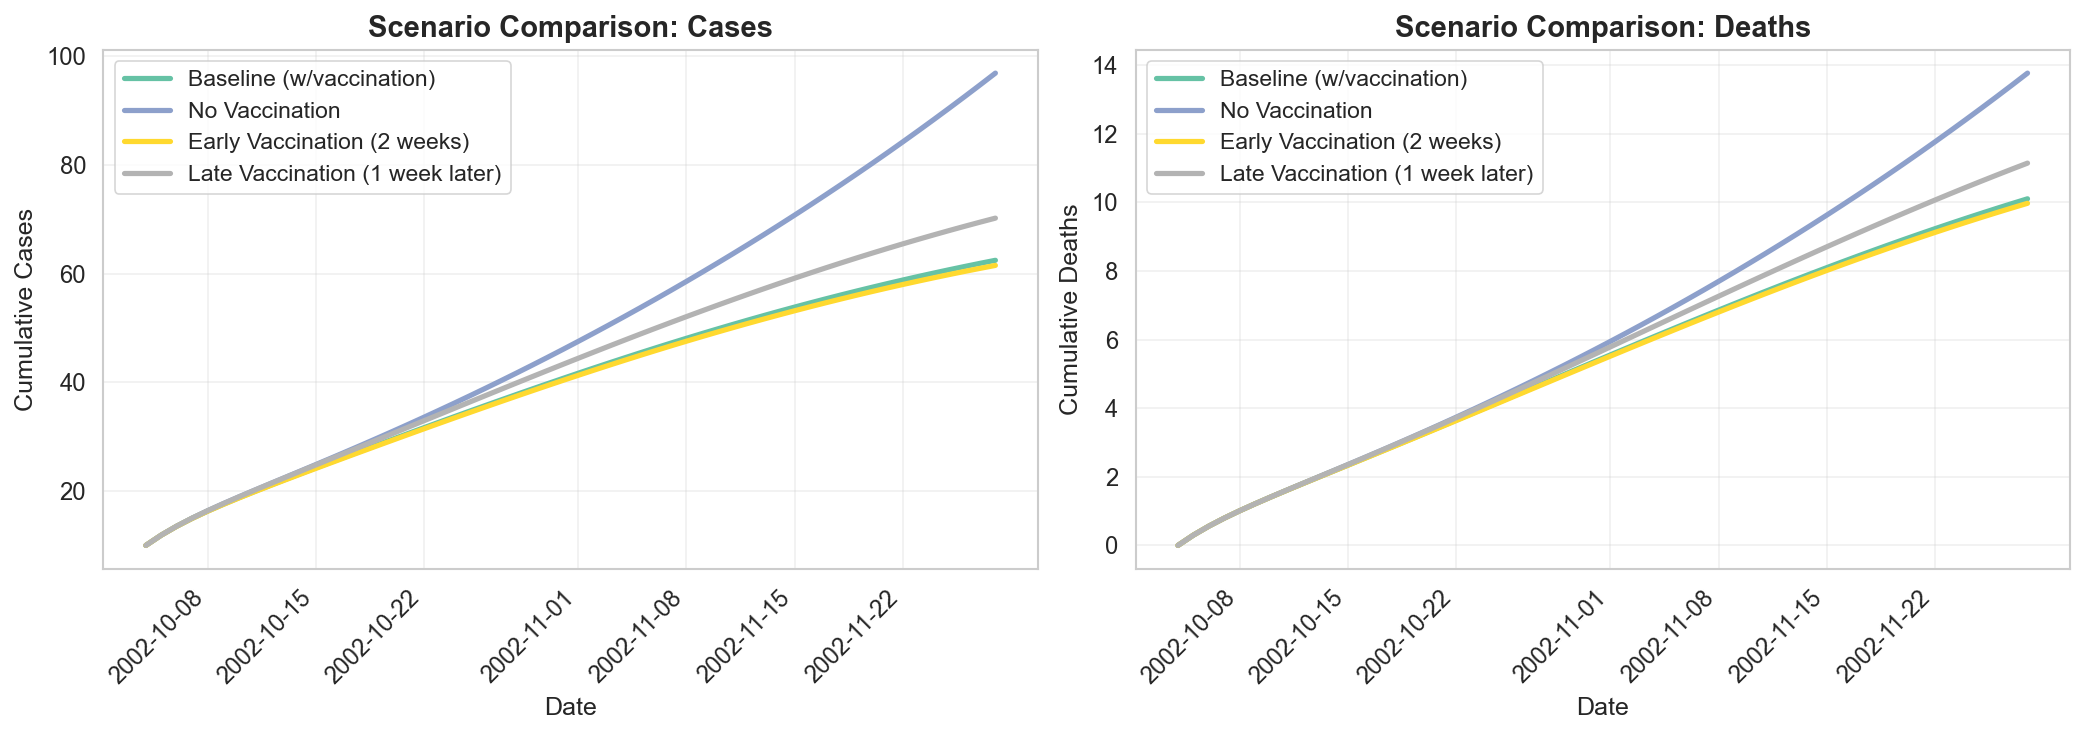

In [102]:
# plot scenario comparison
fig = viz.plot_scenario_comparison(
    scenarios=scenarios,
    metric='both'
)
plt.show()